# Module 2-1 Worksheet: Embedding and Attractor Reconstruction

## Part 1: Computing Optimal Time Delay $\tau$

<font color = 'purple'>
    
*Once we are done talking through the slides from [the main module 2-1 notebook](2-1-Embedding.ipynb), we will take some time to test out your understanding of the method by using the teaspoon functions to estimate the time delay for a different dynamical system. We encourage talking to your neighbor. Please ask if you need help!* The relevant teaspoon functions have been imported below and documentation can be found [here](https://teaspoontda.github.io/teaspoon/index.html) if needed.
    
</font>

### Task: Estimate the takens embedding delay for the periodic Lorenz system using the Teaspoon library functions.

In [1]:
# Embedding/Simulation Functions
import teaspoon.MakeData.DynSysLib.DynSysLib as DSL
from teaspoon.SP.tsa_tools import takens

# Time delay functions
from teaspoon.parameter_selection.delay_LMS import LMSforDelay
from teaspoon.parameter_selection.MsPE import MsPE_tau
from teaspoon.parameter_selection.autocorrelation import autoCorrelation_tau
from teaspoon.parameter_selection.MI_delay import MI_for_delay
from teaspoon.parameter_selection.PAMI_delay import PAMI_for_delay

# Miscellaneous python functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ripser import Rips

# Initialize delay variables
tau_freq, tau_mspe, tau_autocor, tau_mi, tau_pami = 0,0,0,0,0

In [3]:

import sys, os
# sys.path.append(os.path.abspath('..'))
# from research.pkg.lib import *


# import mplfinance as mpf
# %matplotlib inline

import pandas as pd
import matplotlib as mpl

# plt.rcParams['lines.linewidth'] = 0.5 

# mpl.rcParams.update({'font.size': 4, 'lines.linewidth': 0.5, 'figure.dpi': 150})


In [4]:
pair = 'BTC_USDT'
timeframe = '1d'

exchange = 'binance'
odf = pd.read_json(f'../../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.tail(4)

(2114, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2023-05-28,1685232000000,26854.28,28261.32,26764.36,28065.00,43916.00855
2023-05-29,1685318400000,28065.01,28447.14,27524.60,27736.40,42385.41945
2023-05-30,1685404800000,27736.39,28038.59,27554.00,27694.40,32686.75371
2023-05-31,1685491200000,27694.39,27835.51,26839.01,27210.35,46588.80573


## Lorenz System Embedding

The Lorenz system used is defined as

\begin{align*}
\dot{x}&=\sigma (y-x),\\
\dot{y}&=x(\rho−z)−y,\\
\dot{z}&=xy-\beta z.
\end{align*}

In Teaspoon, The Lorenz system is solved with a sampling rate of 100 Hz for 100 seconds with only the last 20 seconds used to avoid transients. For a chaotic response, parameters of σ = 10.0, β = 8.0/3.0, and ρ = 105 and initial conditions [x0,y0,z0] = [10−10,0,1] are used. For a periodic response set ρ = 100.

### Step 1: Simulate the periodic Lorenz System

**Hint:** Use ```
DSL.DynamicSystems('system', 'state')
``` and be sure to save the time and signal in separate variables. The key for this system is *lorenz*.

In [5]:
ts = odf.iloc[-2000:][['close', 'high', 'low']].applymap(np.log).values.T
ts

array([[ 9.59260986,  9.60911515,  9.71643301, ..., 10.23050091,
        10.22898551, 10.21135269],
       [ 9.69703518,  9.6626967 ,  9.7682404 , ..., 10.25580291,
        10.24133705, 10.23406782],
       [ 9.43628001,  9.42286777,  9.60918897, ..., 10.22283543,
        10.22390299, 10.19761171]])

*The correct answer is hidden here. Highlight or double-click to open the cell to see it when you're ready.*

<font color='white'>
    
t, ts = DSL.DynamicSystems('lorenz', 'periodic')
    
</font>

### Step 2: Plot the full state space for this system

Run the code below to plot the 3D state space for the periodic Lorenz system.

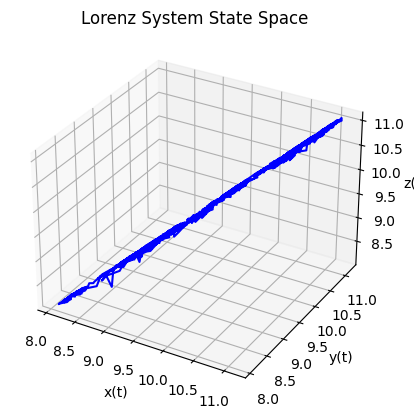

In [6]:
# Define the x, y, and z functions
x = ts[0]
y = ts[1]
z = ts[2]

# Create a figure and add a 3D axis
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the curve using the x, y, and z functions
ax.plot(x, y, z, color='b')

# Add labels and title
ax.set_xlabel('x(t)')
ax.set_ylabel('y(t)')
ax.set_zlabel('z(t)')
ax.set_title('Lorenz System State Space')

# Show the plot
plt.show()

### Step 3: Plot the 1D persistence diagram for this attractor using ripser.

**Note:** Ripser requires an array where the columns correspond to the coordinates and rows are for different points. We use ```np.array()``` and ```np.transpose()```. This computation may take some time. To speed it up a bit, the timeseries can be subsampled by taking every other point (append ```[::2]``` at the end of the ripser input). 

<font color=purple>
Nothing to add here just run the cells to see how ripser works for now.
</font>

In [7]:
# Compute the 1D point cloud persistence diagram for the Lorenz attractor
rips = Rips()
diagrams = rips.fit_transform(np.array(ts).T[::2])
h1pers_true = diagrams[1]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


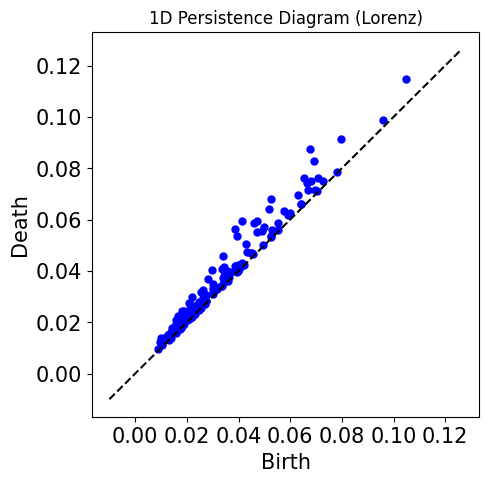

In [8]:
# Plot the diagram
plt.figure(figsize=(5,5), dpi=100)
plt.plot(h1pers_true[:,0], h1pers_true[:,1], '.b', markersize=10)
top = max(np.max(h1pers_true[:,0]),np.max(h1pers_true[:,1]))
plt.plot([-0.01,1.1*top],[-0.01,1.1*top],'--k')
plt.xlabel('Birth', fontsize=15)
plt.ylabel('Death', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('1D Persistence Diagram (Lorenz)')
plt.show()

You should see a clustering of persistence cycles close to the diagonal and two significant features in the diagram that correspond to the two large loops observed in the state space plot.

### Step 4: Estimate the embedding delays using the two methods covered in [module 2-1](2-1-Embedding.ipynb)

Use ```ts[0]``` to estimate the delays. We will use these delays in the next section to evaluate the embedded attractor. *Hint:* Make sure you use the correct sampling frequency, use the ```kraskov 1``` nearest neighbor binning for mutual information.

In [18]:
# Your code here


# tau_mspe = 
# tau_mi = 


# Print your results


# Challenege Problem

# tau_freq = 
# tau_autocor = 
# tau_pami = 

tau_freq = LMSforDelay(ts[0], 10)
    
# tau_mspe = MsPE_tau(ts[0])
    
tau_autocor = autoCorrelation_tau(ts[0])
    
tau_mi = MI_for_delay(ts[0], method='kraskov 1')
    
tau_pami = PAMI_for_delay(ts[0])

print(tau_freq, tau_mspe, tau_autocor, tau_mi, tau_pami)

13 0 443 8 6


*The correct answer is hidden here. Highlight or double-click to open the cell to see it when you're ready.*

<font color='white'>
    
tau_freq = LMSforDelay(ts[0], 100)
    
tau_mspe = MsPE_tau(ts[0])
    
tau_autocor = autoCorrelation_tau(ts[0])
    
tau_mi = MI_for_delay(ts[0], method='kraskov 1')
    
tau_pami = PAMI_for_delay(ts[0])

print(tau_freq, tau_mspe, tau_autocor, tau_mi, tau_pami)
    
DELAYS: 4, 16, 12, 12, 6 
</font>

### Step 5: Plot the embedded attractor in 3 dimensional space using the estimated delays

Explore which methods give the best results when compared to the true state space. The persistence diagram is plotted to the right for comparison to the attractors.

<font color=purple>
    Run the following cell to embed the attractor in 3D for all 5 delays and plot the corresponding 1D persistence diagram. Which method gives the cosest results for this dimension?
</font>

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


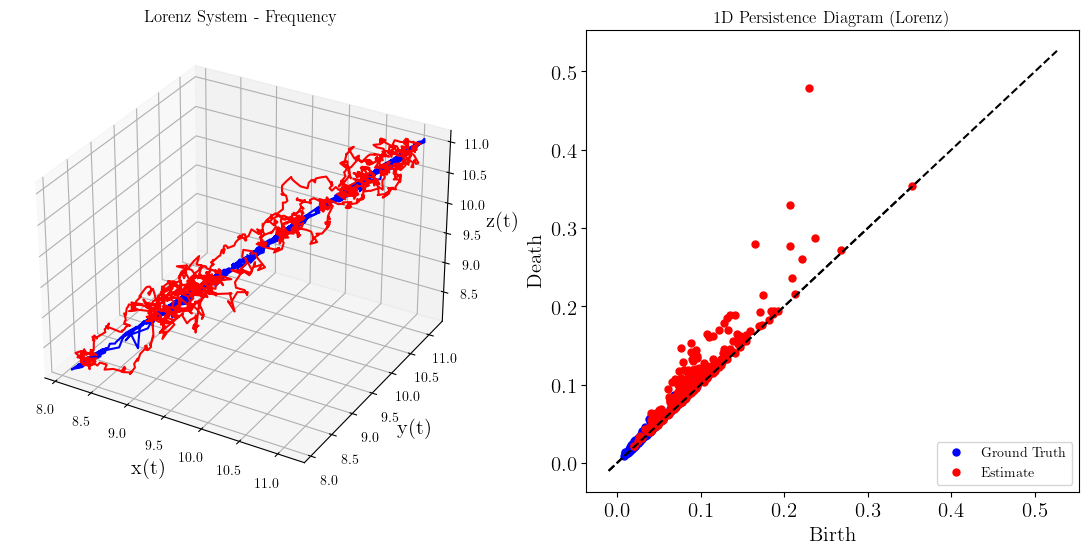

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


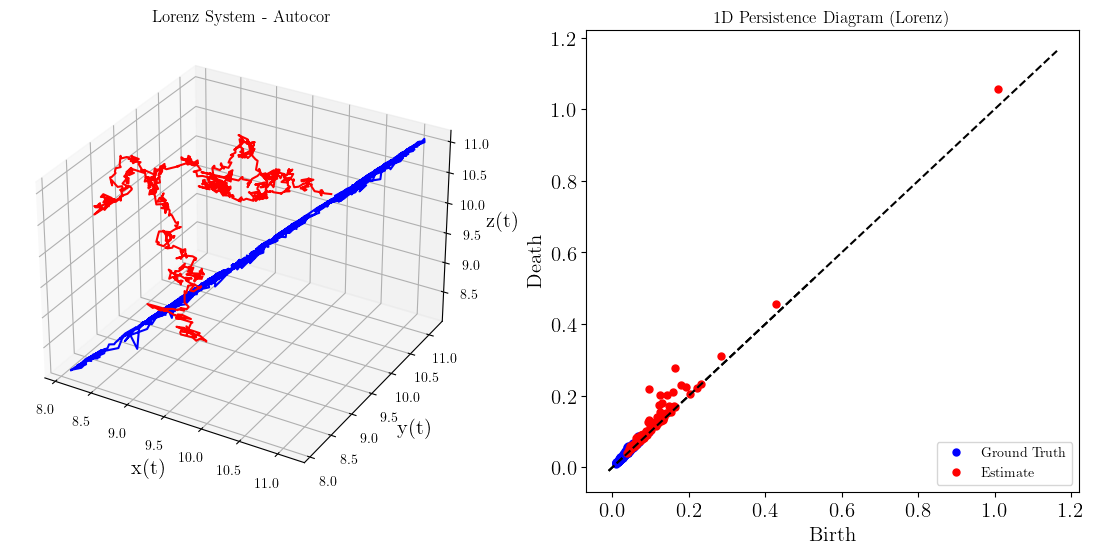

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


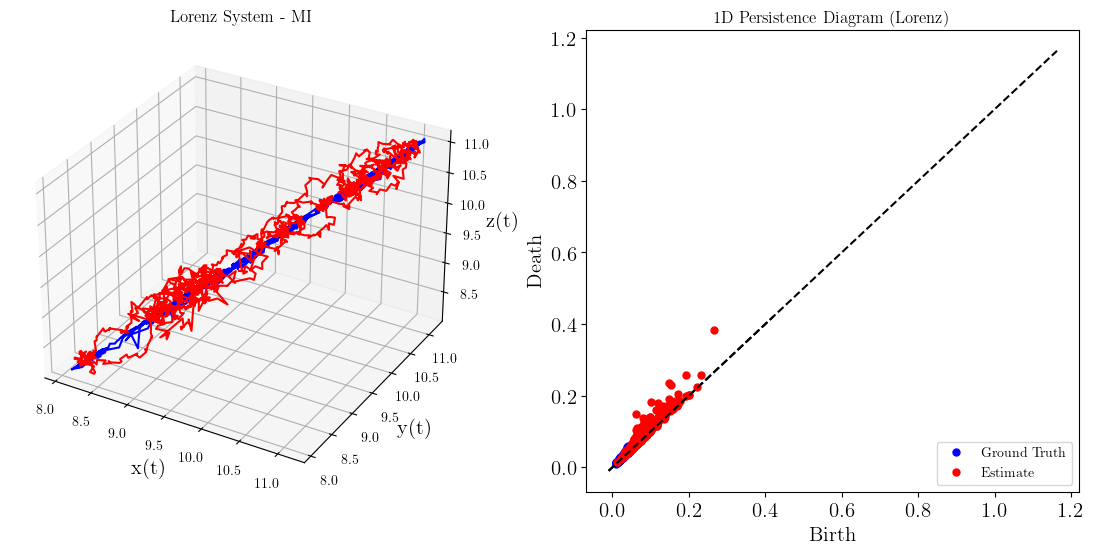

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


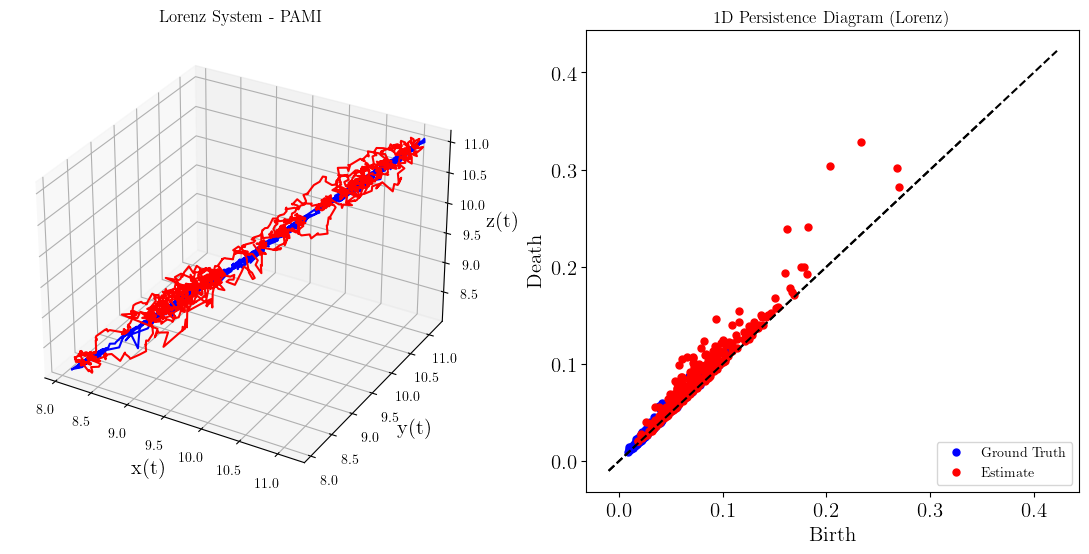

In [19]:
delays = {'Frequency':tau_freq, 
        #   'MSPE':tau_mspe, 
          'Autocor':tau_autocor, 
          'MI':tau_mi, 
          'PAMI':tau_pami}

for method in delays:
    # Embed the attractor:
    if delays[method]:
        embedded_ts = takens(ts[0], n = 3, tau = delays[method])

        # Define the x, y, and z functions
        x_emb = embedded_ts[:,0]
        y_emb = embedded_ts[:,1]
        z_emb = embedded_ts[:,2]

        # Create a figure and add a 3D axis
        fig = plt.figure(figsize=(14,6))
        gs = gridspec.GridSpec(1, 2)
        ax = plt.subplot(gs[0:1, 0:1],projection='3d')

        # Plot the curve using the x, y, and z functions
        ax.plot(x, y, z, color='b')
        ax.plot(x_emb,y_emb, z_emb, color='r')
        # Add labels and title
        ax.set_xlabel('x(t)', fontsize=15)
        ax.set_ylabel('y(t)', fontsize=15)
        ax.set_zlabel('z(t)', fontsize=15)
        ax.set_title(f'Lorenz System - {method}')

        # Plot the persistence diagrams
        ax = plt.subplot(gs[0:1, 1:2])

        # Plot true attractor persistence diagram
        plt.plot(h1pers_true[:,0], h1pers_true[:,1], '.b', markersize=10, label='Ground Truth')
        top_true = max(np.max(h1pers_true[:,0]),np.max(h1pers_true[:,1]))
        plt.plot([-0.01,1.1*top],[-0.01,1.1*top],'--k')

        # Compute and plot embedded attractor persistence diagram
        rips = Rips()
        diagrams = rips.fit_transform(np.array(embedded_ts)[::2])
        h1pers_est = diagrams[1]
        plt.plot(h1pers_est[:,0], h1pers_est[:,1], '.r', markersize=10, label='Estimate')

        # Plot formatting
        top_est = max(np.max(h1pers_est[:,0]),np.max(h1pers_est[:,1]))
        top = max(top_true, top_est)
        plt.plot([-0.01,1.1*top],[-0.01,1.1*top],'--k')
        plt.xlabel('Birth', fontsize=15)
        plt.ylabel('Death', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.title('1D Persistence Diagram (Lorenz)')
        plt.legend(loc='lower right')
        plt.show()

**Challenge Problem:** If you still have time, try to add Gaussian white noise to the original signal data and observe how this changes the persistence diagrams and embedded attractors. Hint: ```use np.random.normal```. 

**Challenge Problem:** Estimate the delays for a system using the methods that were not discussed in the talk. Hint: see the [teaspoon documentation](https://teaspoontda.github.io/teaspoon/parameter_selection.html) for these methods. They are all imported in this notebook. 

**Extra Problem:** Try to embed the chaotic lorenz attractor and observe how the persistence diagrams change when the system is chaotic.





## Code not working? Double click this cell, uncomment the code  and run to see the figures generated in this worksheet.

<!-- ![](figures/2-1-wkst-lorenz-ss.png)
![](figures/2-1-wkst-lorenz-pd.png)
![](figures/2-1-wkst-freq.png)
![](figures/2-1-wkst-mspe.png)
![](figures/2-1-wkst-autocor.png)
![](figures/2-1-wkst-mi.png)
![](figures/2-1-wkst-pami.png) -->

# Stop Here 🛑

---

## Part 2: Estimating the Embedding Dimension $n$

### Task: Estimate the embedding dimension for the periodic Lorenz system using the Teaspoon library functions. 

<font color=red>Warning: You must run all cells in part 1 for this part to work properly</font>

Run your code from part 1 or use the answer keys to simulate the lorenz system. 

In [15]:
# Import dimension functions
from teaspoon.parameter_selection.FNN_n import FNN_n
from teaspoon.parameter_selection.MsPE import MsPE_n

# Initialize dimension variables

n_fnn, n_mspe = 0,0

### Step 1: Estimate the dimensions of the Lorenz system

Use the first component of the state space ```ts[0]``` to estimate the embedding dimension. Note that both dimension methods require a delay to be predetermined. In this case, use the delay from part 1 from the **multiscale permutation entropy (mspe) method**. 

Compute the dimension using the false nearest neighbors and multiscale permutation entropy methods. Are the dimensions correct knowing what the true dimension is for the Lorenz system?

In [20]:
# Your code here

# perc_fnn, n_fnn =
# n_mspe = 

# Print your resulting dimensions

perc_fnn, n_fnn = FNN_n(ts[0], tau_mspe)
    
n_mspe = MsPE_n(ts[0], tau_mspe)
    
print(n_fnn, n_mspe)

9 3


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/teaspoon/parameter_selection/FNN_n.py:208: RuntimeWarning: invalid value encountered in divide
  np.divide(abs(tsrecon[ind_m, -1]-tsrecon[ind, -1]), Dm)-Rtol, 0.5)


*The correct answer is hidden here. Highlight or double-click to open the cell to see it when you're ready.*

<font color='white'>
perc_fnn, n_fnn = FNN_n(ts[0], tau_mspe)
    
n_mspe = MsPE_n(ts[0], tau_mspe)
    
print(n_fnn, n_mspe)
    
Dimensions: 2, 4
</font>

### Step 2: Compute the attractor persistence diagrams

Run the following cell to plot the persistence diagrams for the embedded attractors. Because the dimension may be larger than 3, we only show the persistence diagram here as it is not possible to plot in higher dimensions.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


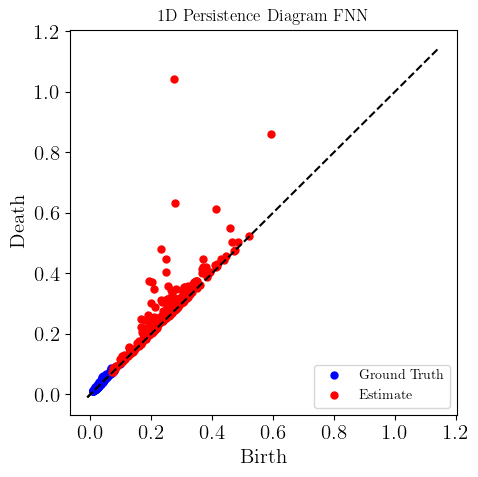

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


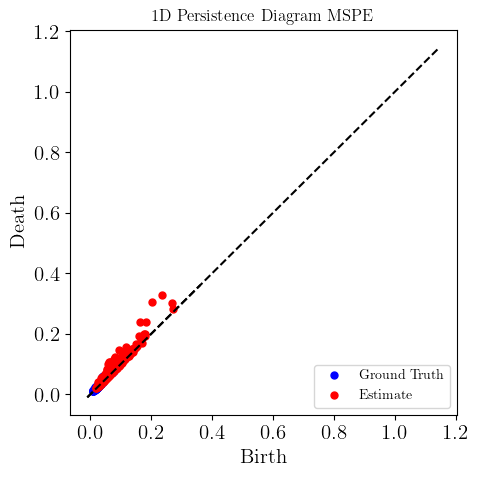

In [21]:
dimensions = {'FNN':n_fnn, 
          'MSPE':n_mspe}

for method in dimensions:
    # Embed the attractor:
    if dimensions[method]:
        embedded_ts = takens(ts[0], n = dimensions[method], tau = tau_pami)

        # Create a figure
        fig = plt.figure(figsize=(5,5))

        # Plot the persistence diagrams


        # Plot true attractor persistence diagram
        plt.plot(h1pers_true[:,0], h1pers_true[:,1], '.b', markersize=10, label='Ground Truth')
        top_true = max(np.max(h1pers_true[:,0]),np.max(h1pers_true[:,1]))
        plt.plot([-0.01,1.1*top],[-0.01,1.1*top],'--k')

        # Compute and plot embedded attractor persistence diagram
        rips = Rips()
        diagrams = rips.fit_transform(np.array(embedded_ts)[::2])
        h1pers_est = diagrams[1]
        plt.plot(h1pers_est[:,0], h1pers_est[:,1], '.r', markersize=10, label='Estimate')

        # Plot formatting
        top_est = max(np.max(h1pers_est[:,0]),np.max(h1pers_est[:,1]))
        top = max(top_true, top_est)
        plt.plot([-0.01,1.1*top],[-0.01,1.1*top],'--k')
        plt.xlabel('Birth', fontsize=15)
        plt.ylabel('Death', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.title(f'1D Persistence Diagram {method}')
        plt.legend(loc='lower right')
        plt.show()

Are the attractor topologies what you expected compared to the ground truth?

**Challenge Problem:** If you still have time, try to add Gaussian white noise to the original signal data and observe how this changes the dimension and persistence diagrams and embedded attractors. Hint: ```use np.random.normal```. 

## Code not working? Double click this cell, uncomment the code  and run to see the figures generated in this worksheet.

<!-- ![](figures/2-1-wkst-fnn.png)
![](figures/2-1-wkst-mspe-dim.png) -->